# Welcome to the final project!
In this notebook you will be asked to use singular value decomposition and SVM to classify images. We will be working with the MNIST numbers dataset, where training data consist of pictures of digits, and the target value is the digit itself.

First, we import the necessary libraries.

In [1]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

Now, we read both training and test dataset as arrays. 

In [2]:
data = np.load('mnist.npz')
X_test_total, X_train_total, y_train_total, y_test_total = data['x_test'], data['x_train'], data['y_train'], data['y_test']

Let's select two digits that we will be learning to separate, for example 3 and 8.

In [3]:
num1, num2 = 3, 8

Let us form the lists of indices i such that the target of i-th object of our training data is either num1 or num2. Do the same for the test dataset.

In [4]:
train_indx = [y == num1 or y == num2 for y in y_train_total] 
# your code here
test_indx = [y == num1 or y == num2 for y in y_test_total] 

Form new arrays consisting of the data with the target values num1 and num2 only. 

In [5]:
X_train, y_train = X_train_total[train_indx], y_train_total[train_indx]
# your code here
X_test, y_test = X_test_total[test_indx], y_test_total[test_indx]

## Looking at the data

Let us check the sizes of the datasets and the shape of one image.

In [6]:
print('Data shapes: ')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

Data shapes: 
X_train:  (11982, 28, 28)
y_train:  (11982,)
X_test:  (1984, 28, 28)
y_test:  (1984,)


In [7]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]

n_train, n_test

(11982, 1984)

In [8]:
print('Shape of one item: ')
print(X_train[0].shape)

Shape of one item: 
(28, 28)


Train data are images of digits.

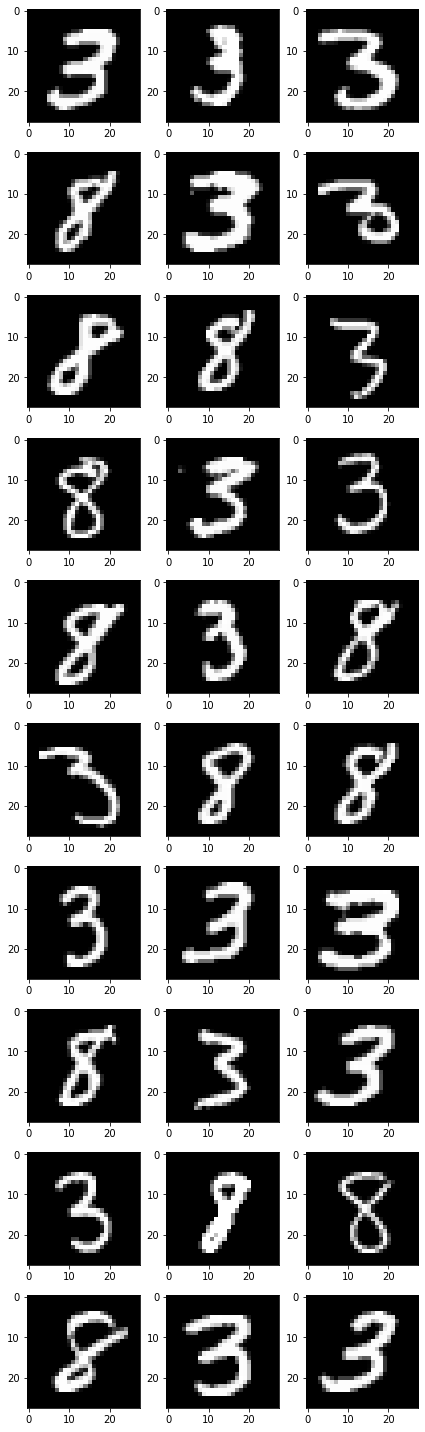

In [9]:
plt.figure(figsize=(6,20))
a, b = 3, 10
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    plt.imshow(X_train[i], cmap='gray')
plt.tight_layout()
plt.show()

Target values are numbers.

In [10]:
y_train[:9]

array([3, 3, 3, 8, 3, 3, 8, 8, 3], dtype=uint8)

## Task 1 (1 point)
Now our data is 3-dimensional of shape (number of images, n_pixels, n_pixels). To work with PCA and SVM we need to flatten the images by turning each of them into an array of shape (n_pixels x n_pixels, ).

In [11]:
def flatten_image(X):
    return np.reshape(X, X.shape[0]*X.shape[1])  # your code here

In [12]:
X_train_flat = np.array([flatten_image(img) for img in X_train])  # np.array([flatten_image(img) for img in X_train])
X_test_flat = np.array([flatten_image(img) for img in X_test])  # your code here
X_train_flat.shape, X_test_flat.shape

((11982, 784), (1984, 784))

PCA works best when the data is scaled (think, why?), so let's scale our data. We will use [StandartScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for it. Note, that scaling replaces a collection of vectors x by the collection of the vectors $x' = (x-M)/D$, where $M$ is the mean vector of
the sample, $D$ is the vector of standard deviations of all components of the vectors, and the division is component-wise. So, the scaled collection has the same size as the original one, and each column has 0 mean and unit standard deviation.


In [13]:
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

## Question 1

Please write your answer on the impact of scaling below. Why does scaling help PCA? If your idea need some computer experiments for confirmation (say, training and accuracy calculations  with non-scaled data), please provide the code here as well.

---
PCA means Principal Component Analysis. This method allows to identify the most important patterns in a dataset by 
<li>firstly, finding the directions of maximum variance in the data, and
<li>secondly, representing the data in a lower-dimensional space by projecting it onto these directions.
<br>
<br>There's a problem, that variables with larger variances or ranges of values may have an excessive influence on the principal components. In order to prevent this, the data should be scaled to have zero mean and unit variance before performing PCA. By doing such scaling we ensure that each variable is given equal weight and therefore it contributes equally to the calculation of the principal components, regardless of its scale or variance.
<br>It leads to more accurate results, as the most important patterns in the data are more likely to be identified.
<br>
Below is an experiment, which uses an open wine dataset and shows post-PCA data clustering for unscaled and scaled data. Apparently, use of unscaled data prevents from defining real key patterns.
    
---

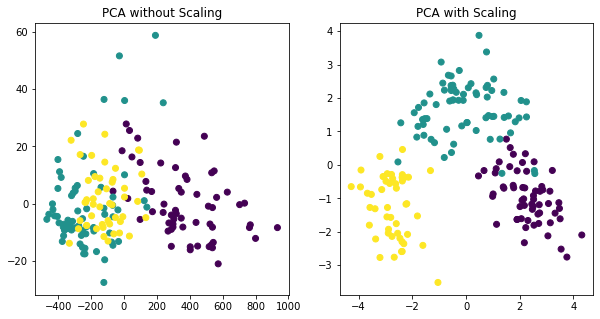

In [14]:
from sklearn.datasets import load_wine

data = load_wine()
A = data.data
b = data.target

pca_test = PCA(n_components=2)
X_pca = pca_test.fit_transform(A)

scaler_test = StandardScaler()
X_scaled = scaler_test.fit_transform(A)
X_pca_scaled = pca_test.fit_transform(X_scaled)

plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=b, cmap='viridis')
plt.title('PCA without Scaling')
plt.subplot(1, 2, 2)
plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=b, cmap='viridis')
plt.title('PCA with Scaling')
plt.show()


Now, we call PCA and reduce the number of components for each vector. 

In [51]:
pca = PCA(n_components=128, random_state=42)
X_train_flat = pca.fit_transform(X_train_flat)

In [16]:
X_test_flat = pca.transform(X_test_flat)

In [17]:
X_train_flat.shape, X_test_flat.shape

((11982, 128), (1984, 128))

## Question 2

What is the ratio of the memory used for the data `compressed' by PCA and the one used for the original data?

---
Having the same number of elements in each dataset we just need to find the ratio of two single elements, one from each set. As it can be seen below there is rather inflation than compression.

---

In [18]:
X_test.shape, X_test[0].nbytes, X_test_flat.shape, X_test_flat[0].nbytes

((1984, 28, 28), 784, (1984, 128), 1024)

In [19]:
X_test[0].nbytes/X_test_flat[0].nbytes, X_test_flat[0].nbytes/X_test[0].nbytes

(0.765625, 1.3061224489795917)

Now, we use SVM with linear kernel to separate the two classes.

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
%%time
# clf = LinearSVC(max_iter=200000, random_state=42)
clf = LinearSVC(random_state=42)
clf.fit(X_train_flat, y_train) 

CPU times: total: 4.47 s
Wall time: 4.66 s


LinearSVC(random_state=42)

Now, let us make the predictions and calculate the accuracy, that is, the ratio of the true predictions to the test sample size.  Use [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) as the quality metric here.

$$accuracy(y\_true, y\_pred) = \frac{1}{n}\sum_{i=1}^n [y\_true_i=y\_pred_i],$$ where $[a=b]=1$, if $a=b$, and $0$ otherwise.

In [22]:
y_pred = clf.predict(X_test_flat)  # your code here
acc = accuracy_score(y_test, y_pred)  # your code here
print("Test accuracy: ", acc)

Test accuracy:  0.9667338709677419


## Try it from your own input
Try to make your own dataset. You can either make a photo image of an ink-written digit or draw a digit using a graphical editor of your computer or smartphone. Note that the input picture has to be a white number on a black background, like the numbers in the MNIST dataset. It can be either in png or jpeg format. Replace the sample striwith your file name. 

In [23]:
from scipy import misc
from PIL import Image

In [24]:
image = Image.open('pics/8_02.png').convert('L')
new_image = image.resize((28, 28))
custom = np.array(new_image)
custom.shape

(28, 28)

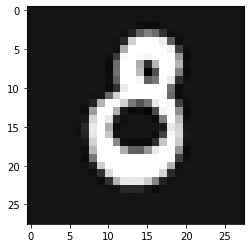

In [25]:
plt.imshow(custom, cmap='gray')
plt.show()

Re-shape your image and make a prediction. 

In [26]:
custom = flatten_image(custom).reshape(1, -1)
custom = scaler.transform(custom)
custom = pca.transform(custom)
custom.shape

(1, 128)

In [27]:
clf.predict(custom)

array([3], dtype=uint8)

## Question 3

Repeat the above digit recognition procedure with other 5 to 10 hand-written images. Do your experiments confirm the above accuracy estimate? How do you think, why they confirm (or not confirm) it?

---
The experiment below shows that the model perfectly recognizez 3 but frequently fails with recognition of 8, so the overall accuracy is about 50%.
Generally, if a model was performing well on the training set but is misclassifying the images that are provided, it is likely that the model is overfitting to the training set.

Overfitting occurs when a model is overtrained, such that it starts to fit the noise in the training data instead of the underlying patterns. In our case this results in a fact that if the model fails to recognize some deeply specific features of 8 it classifies the image as 3 even if there is just a black square. The only correctly recognized image of 8 was copied from the training set.

It is also possible that the misclassification of the images may be due to issues with the image preprocessing or feature extraction. However in our case this does not seem to be the reason as images are being preprocessed and flattened in the same way as the training data, and the features being used for classification are the most relevant ones.

---

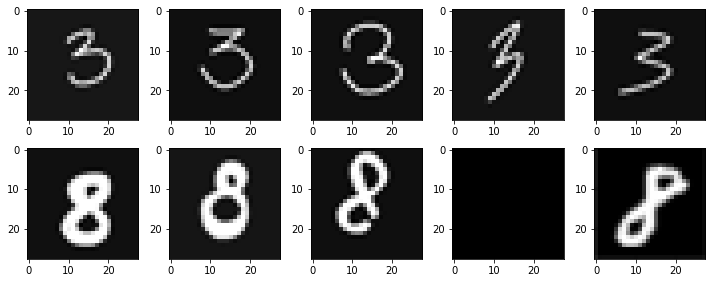

(3, array([3], dtype=uint8), ' Correct')
(3, array([3], dtype=uint8), ' Correct')
(3, array([3], dtype=uint8), ' Correct')
(3, array([3], dtype=uint8), ' Correct')
(3, array([3], dtype=uint8), ' Correct')
(8, array([3], dtype=uint8), 'FALSE recognition')
(8, array([3], dtype=uint8), 'FALSE recognition')
(8, array([3], dtype=uint8), 'FALSE recognition')
(8, array([3], dtype=uint8), 'FALSE recognition')
(8, array([8], dtype=uint8), ' Correct')


In [28]:
output = list()
plt.figure(figsize=(10,4))
a, b = 5, 2
for i in range(a*b):
    plt.subplot(b, a, i+1)
    num = num1 if i < 5 else num2
    img_path = 'pics/' + str(num) + '_0' + str((i % 5) + 1) + '.png' 
    image = Image.open(img_path).convert('L')
    new_image = image.resize((28, 28))
    custom = np.array(new_image)
    plt.imshow(custom, cmap='gray')
    
    custom = flatten_image(custom).reshape(1, -1)
    custom = scaler.transform(custom)
    custom = pca.transform(custom)
    clf_pedict = clf.predict(custom)
    outpust_msg = ' Correct' if num==clf_pedict[0] else 'FALSE recognition'
    output.append((num, clf_pedict, outpust_msg))
    
plt.tight_layout()
plt.show()
print(*output, sep='\n')

In [29]:
def getSingularVectorsLeft(matrix, number=10): # let's take first 10 numbers
    U, S, V = svd(matrix, full_matrices=False)
    # return first _number_ columns of U from SVD of _matrix_
    U_number = U[:, :number]
    return U_number

In [30]:
def getSingularImage(X_train, y_train, number):
    
    # find images whose target is _number_
    select_images = X_train[y_train == number]
    A = np.empty((select_images.shape[1]**2, 0))
    
    for image in select_images:
    # iteratively append new column to form matrix A
        # flattening the image and appending as a column to A
        image_flat = image.reshape(-1, 1)
        A = np.hstack((A, image_flat))
        
    # left_basis = # get left singular vectors
    left_basis = getSingularVectorsLeft(A)
    return left_basis

Try it first on "0".

In [31]:
left_basis = getSingularImage(X_train_total, y_train_total, 0)
print(left_basis.shape)
assert left_basis.shape, (784, 10)

(784, 10)


### Task 2.1 (1 point)
Plot first 9 singular images of the digit 0 taking columns of matrix U and reshaping them back into images 28x28. Use `numpy.reshape`.

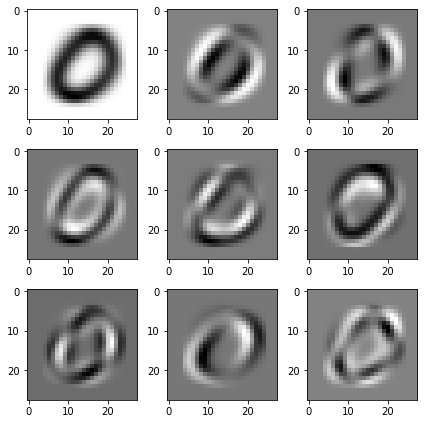

In [32]:
#singular images
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    img = left_basis[:,i].reshape(28, 28)  # ith element of left basis reshaped back to 28x28
    plt.imshow(img, cmap='gray')
    
plt.tight_layout()
plt.show()

## Question 4

Reflect on properties of the columns of $U_k$. What properties do you think are contained in each of them? Draw more singular images to help you make conclusions.

---
The columns of $U_k$ contain the most significant patterns that are present in the data. The first few columns (singular images) correspond to the most dominant patterns. However, as we move towards the later columns, the patterns become less significant and more specific to individual images.

By analyzing more singular images drawn below, we can observe that the dominant patterns captured by the earlier columns of $U_k$ correspond to more general shapes and edges. 

For example, the first few singular images of digit 0 show the dominant patterns of a circle. However, as we move towards the later columns, we observe more specific patterns that correspond to individual variations of the digit 0, such as the thickness, shape and shades of the lines or the curvature of the edges. 

---

In [33]:
def getSingularVectorsLeft_30(matrix, number=30):
    U, S, V = svd(matrix, full_matrices=False)
    U_number = U[:, :number]
    return U_number

def getSingularImage_30(X_train, y_train, number):
    select_images = X_train[y_train == number]
    A = np.empty((select_images.shape[1]**2, 0))
    for image in select_images:
        image_flat = image.reshape(-1, 1)
        A = np.hstack((A, image_flat))
    left_basis = getSingularVectorsLeft_30(A)
    return left_basis

left_basis_30 = getSingularImage_30(X_train_total, y_train_total, 0)

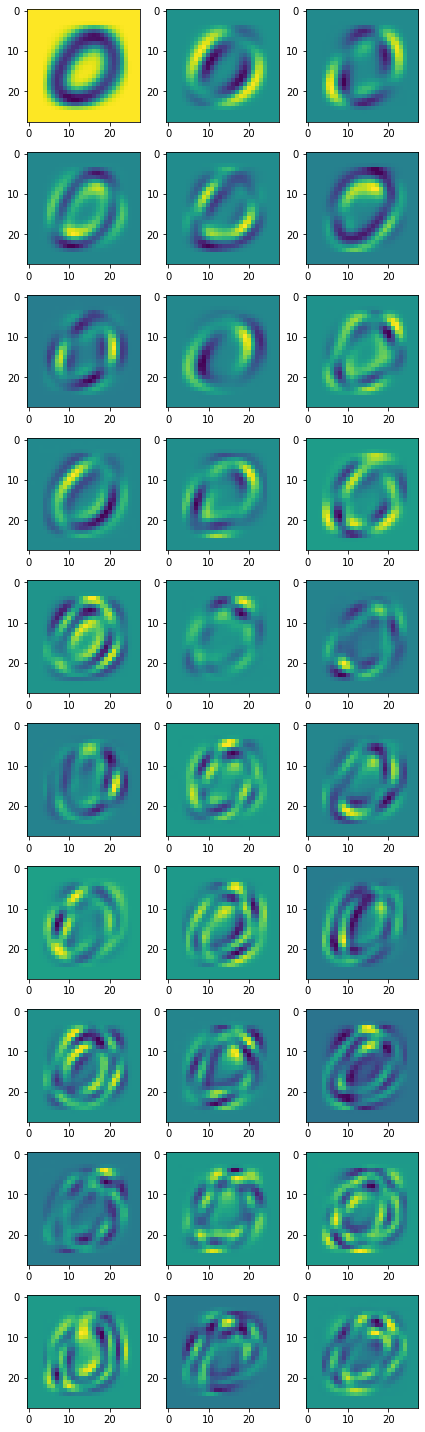

In [34]:
plt.figure(figsize=(6,20))
a, b = 3, 10
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    img = left_basis_30[:,i].reshape(28, 28)
    plt.imshow(img)

plt.tight_layout()
plt.show()

Now let's move on and obtain singular images for all numbers. The matrices $U_k$ from  [the article](https://technodocbox.com/3D_Graphics/77509408-Handwritten-digit-classification-and-reconstruction-of-marred-images-using-singular-value-decomposition.html) are represented as `number_basis_matrices[k]`.
This might take a while to finish, feel free to add debug print in your function to know the progress.

In [35]:
# use getSingularImage funciton to get matrices for all numbers

number_basis_matrices = np.stack([getSingularImage(X_train_total,
                                 y_train_total, number) for number in
                                 range(10)], axis=0)  

In [49]:
number_basis_matrices.shape

(10, 784, 10)

### Task 2.2 (1 point)
Plot the first singular image of each digit, similarly to the previous task.

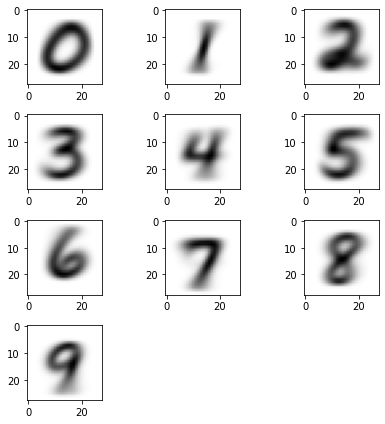

In [37]:
plt.figure(figsize=(6,6))
a, b = 3, 4
for i in range(10):  
    plt.subplot(b, a, i+1)
    img = number_basis_matrices[i][:,0].reshape(28, 28)  # first column of U_k in number_basis_matrices[i] reshaped into 28x28 image
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

In [38]:
dim = number_basis_matrices[0].shape[0]
dim

784

### Task 2.3 (1.5 points)

Here we calculate the new projection matrix for each $U_k$ to apply later in testing:
$pr = (I - U_k \cdot U_{k}^{T})$. Use `numpy.matmul` for matrix multiplication and `numpy.identity` to create an identity matrix. Please note that this operation might also take some time to finish.

In [39]:
# create an array of pr for each number

numeric_values = np.array([np.identity(dim) - np.matmul(U_k, U_k.T)
                          for U_k in number_basis_matrices])

In [40]:
numeric_values.shape

(10, 784, 784)

### Task 2.4 (1.5 points)
Implement function utilizing `numeric_values` matrices to predict labels for unknown images. Use `numpy.norm` and enumerate to iterate over numeric values.

In [41]:
def find_closest(test_value, numeric_values):
    stacked_test = test_value.reshape(-1, 1)
    # find closest U_k to test_value using norm and return the target digit
    distances = [(idx, np.linalg.norm(np.matmul(numeric, stacked_test))) for idx, numeric in enumerate(numeric_values)]
    target = min(distances, key=lambda x: x[1])[0]
    return target

In [42]:
# find array of predictions for test values and calculate accuracy in the cell below
y_pred_total = np.array([find_closest(test_value, numeric_values)
                  for test_value in X_test_total])

In [43]:
acc = accuracy_score(y_test_total, y_pred_total)
print(y_test_total.shape, y_pred_total.shape)
print(y_test_total[0:35])
print(y_pred[0:35])
print("Test accuracy: ", acc)

(10000,) (10000,)
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7]
[3 3 3 3 3 8 3 3 3 8 3 3 3 8 3 8 8 3 8 3 3 8 8 8 8 3 3 3 3 3 8 3 3 8 8]
Test accuracy:  0.9485


## Additional task (2 points)
In the first task we trained Linear SVM to separate 3s and 8s. Here you can implement multiclass classification for _all_ numbers in `MNIST`. Use the same function LinearSVC for “one-vs-the-rest” multi-class strategy, see [the documentation](https://scikit-learn.org/stable/modules/svm.html#classification).  Follow the same steps from task 1: scaling, feature selection, training and testing. Is the accuracy of this method greater then the one calculated above?

**Note:** Use `random_state=42` for `PCA` and `LinearSVC`. Training `LinearSVC` on all the data might take a while, that's normal.

---
The accuracy of this method is about 5% lower than the one calculated above.

---

In [44]:
# flatten
X_train_total_flat = np.array([flatten_image(img) for img in X_train_total])  # np.array([flatten_image(img) for img in X_train])
X_test_total_flat = np.array([flatten_image(img) for img in X_test_total])  # your code here
X_train_total_flat.shape, X_test_total_flat.shape


((60000, 784), (10000, 784))

In [45]:
# Scandart Scaler
scaler_total = StandardScaler()
X_train_total_flat = scaler_total.fit_transform(X_train_total_flat)
X_test_total_flat = scaler_total.transform(X_test_total_flat)

In [46]:
# PCA
pca_total = PCA(n_components=128, random_state=42)
X_train_total_flat = pca_total.fit_transform(X_train_total_flat)
X_test_total_flat = pca_total.transform(X_test_total_flat)
X_train_total_flat.shape, X_test_total_flat.shape

((60000, 128), (10000, 128))

In [47]:
%%time
# LinearSVC
clf_total = LinearSVC(random_state=42)
clf_total.fit(X_train_total_flat, y_train_total)

CPU times: total: 4min 27s
Wall time: 4min 33s


LinearSVC(random_state=42)

In [48]:
y_pred_total = clf_total.predict(X_test_total_flat)
acc = accuracy_score(y_test_total, y_pred_total)
print("Test accuracy: ", acc)

Test accuracy:  0.9079
